"Machine categorising"
-----------------------
This is a script by Elden to attempt to classify the centrality space by trawling the infomation listed in the String db 

In [90]:
"""Imports and arguments"""

import csv

import string

import networkx as nx

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import network_utilities as nu
import random
import networkx.algorithms.community as nx_comm
import tensorflow as tf

# some basic settings for plotting figures
%matplotlib inline 
font = {'family' : 'serif',
        'weight' : 'light',
        'size'   : 20}

plt.rc('font', **font)

extra_outputs = False;

In [2]:
"""Loading data"""

# This is the variable that will store the protein names. 
ess_list = []; 

with open('essential_proteins.csv', newline='') as ess_file:
    reader = csv.reader(ess_file)
    ess_data = list(reader)

for i in range(len(ess_data)):
    ess_list.append(ess_data[i][1])
    
# Read in the string-db for Yeast
G0 = nx.read_weighted_edgelist("./yeast_protein_edgelist_trimmed.txt",comments="#",nodetype=str)

# For interest, plot the distribution of confidence scores
if (extra_outputs):
    plt.figure(figsize=(6,6));
    full_edges = G0.edges()
    these_weights = [G0[u][v]['weight'] for u,v in full_edges]

    plt.hist(these_weights, bins=40);
    plt.title("Confidence score distribution")
    plt.xlabel("Confidence score")
    plt.ylabel("# Edges")
    plt.show();
    
# delete those edges with a combined score of <= threshold_score (small confidence)
threshold_score = 700;
for edge in G0.edges: 
    weight = list(G0.get_edge_data(edge[0],edge[1]).values())
    if(weight[0] <= threshold_score):
        G0.remove_edge(edge[0],edge[1])
        
# Take only the largest connected subgraph
largest_cc = max(nx.connected_components(G0),key=len)
G = G0.subgraph(largest_cc);
print(G)

Graph with 5932 nodes and 119977 edges


In [3]:
# Let's generate the binary array to color nodes:

ess_selector = nu.value_lambda_result(
    list(G.nodes), # values
    [lambda p: p in ess_list], # tests
    [1], # results
    default = 0); 

ess_colors = ['red' if k == 1 else 'blue' for k in ess_selector]

# and some random names:
rand_name_period = 100

name_list_full = list(G.nodes) 
name_list_cutdown = [name_list_full[n] if n % rand_name_period == 0 else None for n in range(len(name_list_full))]
just_one_name = [name if name == "YPT232W" else None for name in name_list_full]

Let's look at the distribution of nodes w.r.t. a few properties, colored by essentiality, to see if we can see any trends.

Each cell runs an individual measure for processing efficiency, then the chosen two are run by the last cell. The cells are roughly ordered in order of runtime.

In [4]:
degrees_labeled = list(G.degree);
degrees = [d[1] for d in degrees_labeled] # stripping away the labels

In [5]:
eigen_centrality = list(nx.eigenvector_centrality(G).values())

Now we plot the desired pairs:

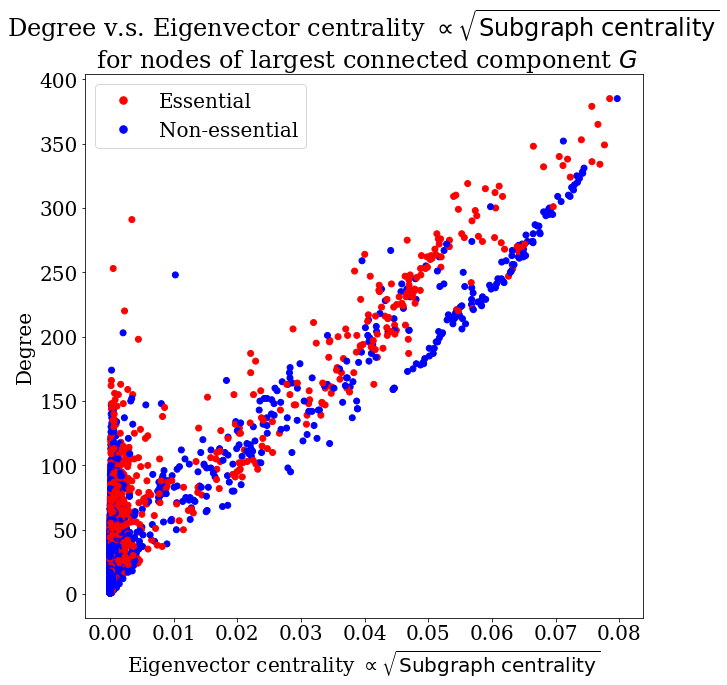

In [6]:
plt.figure(figsize=(10,10))
plt.scatter(eigen_centrality, degrees, c = ess_colors)
plt.title("Degree v.s. Eigenvector centrality $\propto\sqrt{\mathrm{Subgraph\;centrality}}$\n for nodes of largest connected component $G$")
plt.xlabel("Eigenvector centrality $\propto \sqrt{\mathrm{Subgraph\;centrality}}$");
plt.ylabel("Degree")

# Compose a custom legend to label the colors:
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='.', color='red', label='Essential',
                          markerfacecolor='red', markersize=15, linewidth=0),
                   Line2D([0], [0], marker='.', color='blue', label='Non-essential',
                          markerfacecolor='blue', markersize=15, linewidth=0)]

plt.legend(handles=legend_elements, loc='best')


# Naming shenanigans
# To zoom in:
naming_nodes = False
if (naming_nodes):
    Zooming_in = False
    if (Zooming_in):
        x_min = 0
        x_max = 0.001
        y_min = 0 
        y_max = 50
        plt.xlim([x_min,x_max])
        plt.ylim([y_min,y_max])
        for i in range(len(eigen_centrality)):
            if (name_list_cutdown[i] is not None):
                if (eigen_centrality[i] > x_min and eigen_centrality[i] < x_max
                   and degrees[i] > y_min and degrees[i] < y_max):
                    plt.text(eigen_centrality[i], degrees[i],name_list_cutdown[i], fontsize=10)
    else:
        for i in range(len(eigen_centrality)):
            if (name_list_cutdown[i] is not None):
                plt.text(eigen_centrality[i], degrees[i],name_list_cutdown[i], fontsize=10)

just_one = True
if (just_one):
    for i in range(len(eigen_centrality)):
        if (just_one_name[i] is not None):
            plt.text(eigen_centrality[i], degrees[i],just_one_name[i], fontsize=10)
        

plt.show()

### Observations

We see that subgraph and eigenvector centrality almost exactly correlate:

In [175]:
# Let's try to read the information list

with open('protein_info_list.txt', newline='') as file:
    reader = csv.reader(file, delimiter='\t')
    prot_info = list(reader)

# The collums are:
# ID    Common name     Size      Info
    
i_info = 3 # just to store which collumn contains the info

# Let's write a function that converts a name to an annotation:
def get_info(name):
    for i in range(len(prot_info)):
        if (name == prot_info[i][0]):
            return prot_info[i][i_info]
    return None

example_prot = "YAR009C";
print("Protein", example_prot, "has info: ''", get_info(example_prot), "''")

# Now a function that returns all the names with corresponding descriptions containing a given string
def get_by_info(search_term, case_sensitive=False):
    names = []
    if (not case_sensitive):
        for i in range(len(prot_info)):
            if (search_term.lower() in prot_info[i][i_info].lower()): # .lower() makes it case insensitive
                names.append(prot_info[i][0])
    else:
        for i in range(len(prot_info)):
            if (search_term in prot_info[i][i_info]): # case sensitive
                names.append(prot_info[i][0])
    return names

get_by_info("Gag")

Protein YAR009C has info: '' Truncated transposon Ty1-A Gag-Pol polyprotein; Retrotransposon TYA Gag and TYB Pol genes; Gag processing produces capsid proteins, Pol is cleaved to produce protease, reverse transcriptase and integrase activities; in YARCTy1-1 TYB is mutant and probably non-functional; protein product forms cytoplasmic foci upon DNA replication stress ''


['YAR009C',
 'YAR010C',
 'YBL005W-A',
 'YBL005W-B',
 'YBL100W-A',
 'YBL100W-B',
 'YBR012W-A',
 'YBR012W-B',
 'YCL019W',
 'YCL020W',
 'YDR034C-C',
 'YDR034C-D',
 'YDR098C-A',
 'YDR098C-B',
 'YDR170W-A',
 'YDR210C-C',
 'YDR210C-D',
 'YDR210W-A',
 'YDR210W-B',
 'YDR261C-C',
 'YDR261C-D',
 'YDR261W-A',
 'YDR261W-B',
 'YDR316W-A',
 'YDR316W-B',
 'YDR365W-A',
 'YDR365W-B',
 'YDR496C',
 'YER137C-A',
 'YER138C',
 'YER159C-A',
 'YER160C',
 'YFL002W-A',
 'YFL002W-B',
 'YFR001W',
 'YGR027W-A',
 'YGR027W-B',
 'YGR038C-A',
 'YGR038C-B',
 'YGR109W-A',
 'YGR109W-B',
 'YGR161C-C',
 'YGR161C-D',
 'YGR161W-A',
 'YGR161W-B',
 'YHL009W-A',
 'YHL009W-B',
 'YHR214C-B',
 'YHR214C-C',
 'YIL082W',
 'YIL082W-A',
 'YJL113W',
 'YJL114W',
 'YJR026W',
 'YJR027W',
 'YJR028W',
 'YJR029W',
 'YLR035C-A',
 'YLR157C-A',
 'YLR157C-B',
 'YLR192C',
 'YLR207W',
 'YLR227W-A',
 'YLR227W-B',
 'YLR256W-A',
 'YLR394W',
 'YLR410W-A',
 'YLR410W-B',
 'YML039W',
 'YML040W',
 'YML045W',
 'YML045W-A',
 'YMR045C',
 'YMR046C',
 'YMR050C'

In [176]:
# We now want to color by containing a given term
color_search_term = "protease"

search_name_array = get_by_info(color_search_term);

search_selector = nu.value_lambda_result(
    list(G.nodes), # values
    [lambda p: p in search_name_array], # tests
    [1], # results
    default = 0); 

print("There were", np.sum(search_selector), "matches")

search_colors = ['orange' if k == 1 else 'blue' for k in search_selector]

There were 86 matches


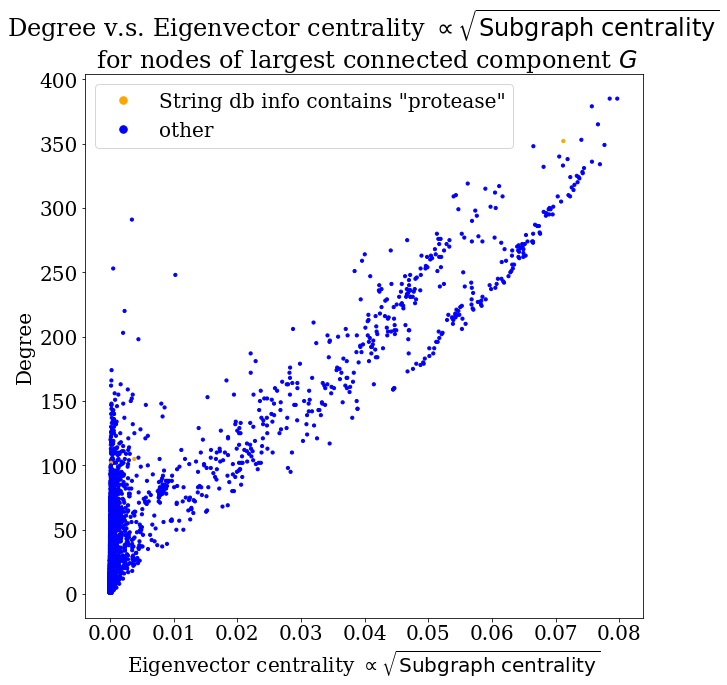

In [177]:
plt.figure(figsize=(10,10))
plt.scatter(eigen_centrality, degrees, c = search_colors, s=10)
plt.title("Degree v.s. Eigenvector centrality $\propto\sqrt{\mathrm{Subgraph\;centrality}}$\n for nodes of largest connected component $G$")
plt.xlabel("Eigenvector centrality $\propto \sqrt{\mathrm{Subgraph\;centrality}}$");
plt.ylabel("Degree")

# Compose a custom legend to label the colors:
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='.', color='orange', label="String db info contains \""+str(color_search_term)+"\"",
                          markerfacecolor='orange', markersize=15, linewidth=0),
                   Line2D([0], [0], marker='.', color='blue', label='other',
                          markerfacecolor='blue', markersize=15, linewidth=0)]

plt.legend(handles=legend_elements, loc='best')

In [157]:
# To give us interesting key-words, let's order ALL of the words in the string db info by frequency
info_texts = [line[i_info] for line in prot_info] # just the info strings in a list
 
all_separate_words = []
for line in info_texts:
    raw_line = line.translate(str.maketrans('', '', string.punctuation))
    for word in raw_line.split(" "):
        all_separate_words.append(word) # We ARE being case sensitive here... otherwise it messes with things like 'ATPase'


In [158]:
unique_words = []
unique_counts = []

for word in all_separate_words:
    if (word in unique_words): 
        unique_counts[unique_words.index(word)] += 1; # up the existing count if already in
    else: 
        unique_words.append(word) # add to the seen words list
        unique_counts.append(1) # append a new count of 1

# Wrap into a dict:

word_freq_dict_unsorted = dict(zip(unique_words, unique_counts))
# now we sort it from largest to smallest:
word_freq_dict = dict(sorted(word_freq_dict_unsorted.items(), key=lambda item: -item[1]))

# A one line solution would be this \/ ... but too slow?
# word_freq_dict = {word : all_separate_words.count(word) for word in list(set(all_separate_words))};

print(word_freq_dict)

{'the': 9791, 'of': 8917, 'to': 7244, 'protein': 7211, 'and': 6691, 'in': 5894, 'a': 4105, 'for': 2480, 'with': 2457, 'that': 2087, 'involved': 2024, 'is': 1893, 'complex': 1760, 'family': 1733, 'from': 1627, 'by': 1582, 'has': 1576, 'required': 1552, 'Putative': 1488, 'Belongs': 1212, 'function': 1205, 'DNA': 1194, 'subunit': 1178, 'Protein': 1139, 'membrane': 1123, 'paralog': 1107, 'duplication': 1105, 'genome': 1102, 'arose': 1090, 'whole': 1022, 'unknown': 1006, 'on': 949, 'stress': 885, 'mitochondrial': 841, 'gene': 841, 'response': 793, 'sequence': 786, 'human': 778, 'replication': 772, 'functional': 737, 'based': 724, 'proteins': 720, 'reading': 705, 'open': 702, 'frame': 700, 'encode': 686, 'Dubious': 682, 'data': 682, 'unlikely': 681, 'factor': 671, 'uncharacterized': 670, 'comparative': 661, 'available': 658, 'experimental': 657, 'Uncharacterized': 640, 'as': 612, 'transcription': 602, 'an': 589, 'expression': 589, 'localizes': 584, 'during': 581, 'interacts': 576, 'mutant': 

In [159]:
# let's just take the first few terms to analyse:
n_terms = 200
cutdown_word_freq_dict = {k: word_freq_dict[k] for k, _ in zip(word_freq_dict, range(n_terms))}
print(cutdown_word_freq_dict)

{'the': 9791, 'of': 8917, 'to': 7244, 'protein': 7211, 'and': 6691, 'in': 5894, 'a': 4105, 'for': 2480, 'with': 2457, 'that': 2087, 'involved': 2024, 'is': 1893, 'complex': 1760, 'family': 1733, 'from': 1627, 'by': 1582, 'has': 1576, 'required': 1552, 'Putative': 1488, 'Belongs': 1212, 'function': 1205, 'DNA': 1194, 'subunit': 1178, 'Protein': 1139, 'membrane': 1123, 'paralog': 1107, 'duplication': 1105, 'genome': 1102, 'arose': 1090, 'whole': 1022, 'unknown': 1006, 'on': 949, 'stress': 885, 'mitochondrial': 841, 'gene': 841, 'response': 793, 'sequence': 786, 'human': 778, 'replication': 772, 'functional': 737, 'based': 724, 'proteins': 720, 'reading': 705, 'open': 702, 'frame': 700, 'encode': 686, 'Dubious': 682, 'data': 682, 'unlikely': 681, 'factor': 671, 'uncharacterized': 670, 'comparative': 661, 'available': 658, 'experimental': 657, 'Uncharacterized': 640, 'as': 612, 'transcription': 602, 'an': 589, 'expression': 589, 'localizes': 584, 'during': 581, 'interacts': 576, 'mutant': 

In [ ]:
# Can we detect "good clustering" in the phase space somehow, to identify spacially meaningful keywords?